<a href="https://colab.research.google.com/github/RitvikPrabhu/Machine-Learning/blob/master/Pattern_Prediction/Neural_Networks_function_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Time Series Forecasting** 
####*Ritvik Prabhu*


The following notebook depicts two instances of time series forecasting. The library used in each instance is Keras.

First, we will import necessary packages

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from keras.layers import TimeDistributed
#custom cmap
mymap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])

params = {'legend.fontsize': 20,
          'figure.figsize': (15,10),
          'axes.labelsize': 25,
          'axes.titlesize': 25,
          'xtick.labelsize': 25*0.75,
          'ytick.labelsize': 25*0.75,
          'legend.title_fontsize': 25,
          'axes.titlepad': 25}
plt.rcParams.update(params)

import numpy as np
from scipy.stats import truncnorm

# Progress bar for long runs
#from tqdm.notebook import tqdm    # Use this if running the jupyter notebook directly
from tqdm import tqdm       # Use this if running in binder or colab
import tensorflow_addons as tfa

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# fix random seed for reproducibility
np.random.seed(0)

import keras
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
from keras.layers import ConvLSTM2D
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from IPython.display import clear_output
from keras.layers import LeakyReLU

Using TensorFlow backend.


The approach to be considered in order to implement models of time series forecasting is the use of **Recurrent Neural Networks (RNN)**. However, Vanilla RNNs suffer from the vanishing and exploding gradient problem during back propogation. Due to the absence of a stable gradient signal during training, RNNs are unable to model long-term sequential models. 

The solution to this using an artificial RNN architecture called **Long Short Term Memory (LSTM)**. LSTMs *can* model long-term sequential model.  LSTM allows the preservation of gradients and hence prevents the problem of vanishing and exploding gradients during back propogation. 

### **1) Function Prediction**

#### **a) Loading Dataset**
LSTM will learn a function that maps a sequence of past observations as input to an output observation. The create_dataset() function implements this behavior and will split a given univariate sequence into multiple samples where each sample has a specified number of time steps and the output is a single time step.


The dataset is created by creating an array of N data points from 0 to 15. We then call the function cos(x) + 2cos(2x) + 3cos(3x) + 4cos(4x) + 5cos(5x) + 6cos(6x) + 7cos(7x) + 8cos(8x) + 9cos(9x) + 10cos(10x) to the above array. This is essentially the data we use for the network.


It is essential to normalize the data before passing into the network in order to prevent problems exploding and vanishing gradients while the data is passed through the activation function.


An important parameter to consider is the look_back value. This value determines the number of timesteps to consider as an input for a single timestep output. The formula to select the minimum value of look_back:

# $$\frac{2\pi}{min\left(\left[\omega\right] \right)*\triangle t}$$
where, $\triangle t$ = is the time step in the X array and $min\left(\left[\omega\right] \right)$ = frequency associated with the function with the smallest frequency

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            240400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             30200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 290,851
Trainable params: 290,851
Non-trainable params: 0
_________________________________________________________________


Restoring model weights from the end of the best epoch
Epoch 00085: early stopping

Train Score: 0.11 RMSE
Test Score: 0.09 RMSE


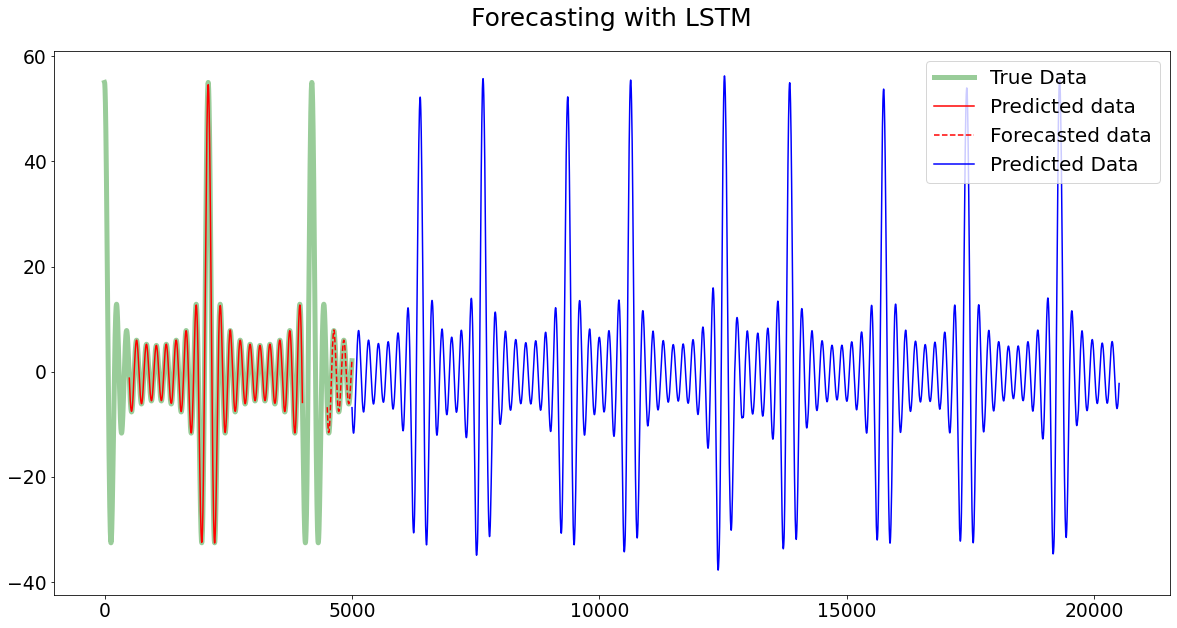

In [16]:
N = 5000
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# load the dataset
X = np.linspace(0, 15, N)
Y = 10*(np.cos(10*X)) + 9*(np.cos(9*X)) + 8*(np.cos(8*X)) + \
7*(np.cos(7*X)) + 6*(np.cos(6*X)) + 5*(np.cos(5*X)) + 4*(np.cos(4*X)) +\
3*(np.cos(3*X)) + 2*(np.cos(2*X)) + np.cos(X)


dataset = Y.reshape(Y.size, 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets with the ratio 80%:20%
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


# reshape into X=t and Y=t+1
look_back = 500
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


# create and fit the LSTM network
keras.backend.clear_session()
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(50, return_sequences=True, input_shape=(1, look_back)))
model.add(LSTM(50, activation='relu', input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
es = EarlyStopping(monitor='loss', mode = 'min', verbose=1, patience = 20, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, )
model.summary()
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=0, callbacks=[es,tqdm_callback])



# make predictions
trainPredict = model.predict(trainX)  
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)

trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset), 'g', linewidth=5, alpha=0.4, label='True Data')
plt.plot(trainPredictPlot, color = 'red', label = 'Predicted data')
plt.plot(testPredictPlot, '--' , color = 'red', label = 'Forecasted data')
plt.legend()
plt.title('Forecasting with LSTM')

##########################################################################################################

#Prediction
    
num_pred = 15000

#Create dataset for network
Input = []
for i in range(0,len(dataset),look_back):
  temp = np.array([])
  for j in range(look_back):
    temp = np.append(temp,float(dataset[i+j]))
  Input.append(temp)

# Network Prediction

x = list(Input[-1])

for i in range(int(num_pred)+1):
  data = np.array(x[i:i+look_back]).reshape(1,1,look_back)
  result = model.predict(data)
  x.append(float(result))

x = np.array(x)
x = np.reshape(x,(x.shape[0],1))
PredictPlot = scaler.inverse_transform(x)
res = np.arange(N,N+len(Y[-look_back:])+num_pred+1)

plt.plot(res, PredictPlot, label = 'Predicted Data', c = 'b')

plt.legend()


plt.show()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 100)            220400    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1, 100)            60400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 361,301
Trainable params: 361,301
Non-trainable params: 0
_________________________________________________________________


Restoring model weights from the end of the best epoch
Epoch 00086: early stopping

Train Score: 0.13 RMSE
Test Score: 0.13 RMSE


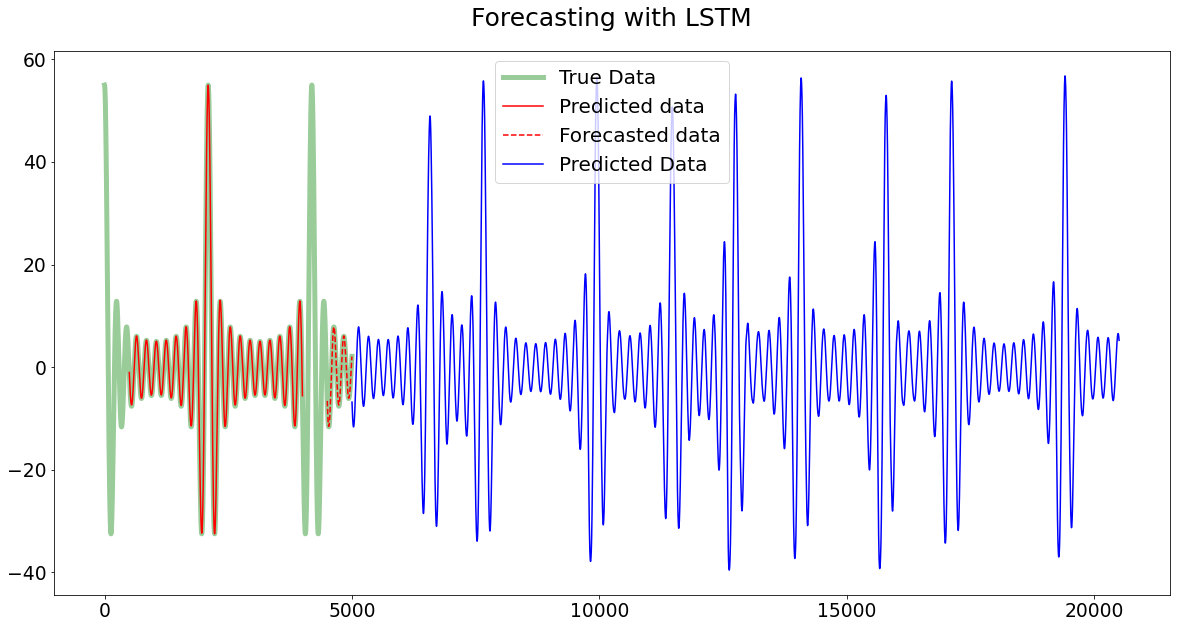

In [ ]:
N = 5000
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# load the dataset
X = np.linspace(0, 15, N)
Y = 10*(np.cos(10*X)) + 9*(np.cos(9*X)) + 8*(np.cos(8*X)) + \
7*(np.cos(7*X)) + 6*(np.cos(6*X)) + 5*(np.cos(5*X)) + 4*(np.cos(4*X)) +\
3*(np.cos(3*X)) + 2*(np.cos(2*X)) + np.cos(X)


dataset = Y.reshape(Y.size, 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * (0.8))
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


# reshape into X=t and Y=t+1
look_back = 500
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


# create and fit the LSTM network
keras.backend.clear_session()
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(1, look_back)))
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(1, look_back)))
model.add(LSTM(100, activation='relu', input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
es = EarlyStopping(monitor='loss', mode = 'min', verbose=1, patience = 20, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, )
model.summary()
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=0, callbacks=[es,tqdm_callback])



# make predictions
trainPredict = model.predict(trainX)  
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)

trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset), 'g', linewidth=5, alpha=0.4, label='True Data')
plt.plot(trainPredictPlot, color = 'red', label = 'Predicted data')
plt.plot(testPredictPlot, '--' , color = 'red', label = 'Forecasted data')
plt.legend()
plt.title('Forecasting with LSTM')

##########################################################################################################

#Prediction
    
num_pred = 15000

#Create dataset for network
Input = []
for i in range(0,len(dataset),look_back):
  temp = np.array([])
  for j in range(look_back):
    temp = np.append(temp,float(dataset[i+j]))
  Input.append(temp)

# Network Prediction

x = list(Input[-1])

for i in range(int(num_pred)+1):
  data = np.array(x[i:i+look_back]).reshape(1,1,look_back)
  result = model.predict(data)
  x.append(float(result))

x = np.array(x)
x = np.reshape(x,(x.shape[0],1))
PredictPlot = scaler.inverse_transform(x)
res = np.arange(N,N+len(Y[-look_back:])+num_pred+1)

plt.plot(res, PredictPlot, label = 'Predicted Data', c = 'b')

plt.legend()


plt.show()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 249, 64)        33536     
_________________________________________________________________
flatten_1 (Flatten)          (None, 15936)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15937     
Total params: 49,473
Trainable params: 49,473
Non-trainable params: 0
_________________________________________________________________


Restoring model weights from the end of the best epoch
Epoch 00095: early stopping

Train Score: 0.20 RMSE
Test Score: 0.17 RMSE


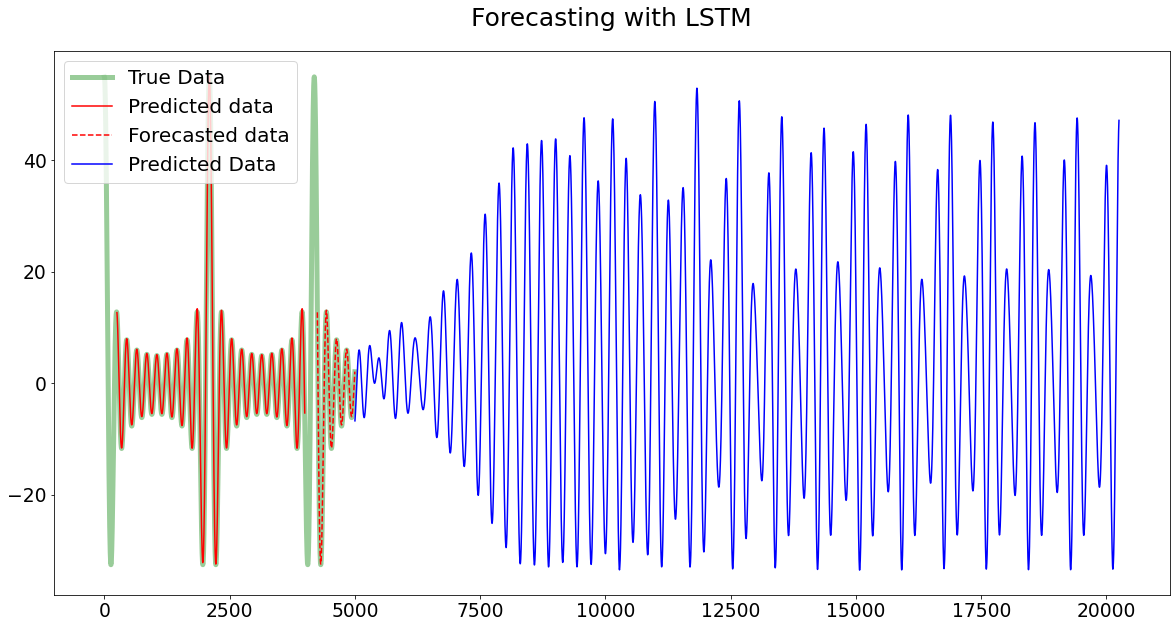

In [13]:
N = 5000
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# load the dataset
X = np.linspace(0, 15, N)
difference = X[1]-X[0]
Y = 10*(np.cos(10*X)) + 9*(np.cos(9*X)) + 8*(np.cos(8*X)) + \
7*(np.cos(7*X)) + 6*(np.cos(6*X)) + 5*(np.cos(5*X)) + 4*(np.cos(4*X)) +\
3*(np.cos(3*X)) + 2*(np.cos(2*X)) + np.cos(X)


dataset = Y.reshape(Y.size, 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
 

# split into train and test sets
train_size = int(len(dataset) * (0.8))
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


# reshape into X=t and Y=t+1
look_back = 200
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input to be [samples, time steps, rows, columns, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, 1, look_back, 1))
testX = np.reshape(testX, (testX.shape[0], 1, 1, look_back, 1))


# create and fit the LSTM network
keras.backend.clear_session()
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(1, 1, look_back, 1)))
# IGNORE: LeakyReLU(alpha=0.1)
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
es = EarlyStopping(monitor='loss', mode = 'min', verbose=1, patience = 20, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, )
model.summary()
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=0, callbacks=[es,tqdm_callback])


# make predictions
trainPredict = model.predict(trainX)  
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)

trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset), 'g', linewidth=5, alpha=0.4, label='True Data')
plt.plot(trainPredictPlot, color = 'red', label = 'Predicted data')
plt.plot(testPredictPlot, '--' , color = 'red', label = 'Forecasted data')
plt.legend()
plt.title('Forecasting with LSTM')

##########################################################################################################

#Prediction
    
num_pred = 15000

#Create dataset for network
Input = []
for i in range(0,len(dataset),look_back):
  temp = np.array([])
  for j in range(look_back):
    temp = np.append(temp,float(dataset[i+j]))
  Input.append(temp)

# Network Prediction

x = list(Input[-1])

for i in range(int(num_pred)+1):
  data = np.array(x[i:i+look_back])
  data = data.reshape(1,1, 1, look_back, 1)
  result = model.predict(data)
  x.append(float(result))

x = np.array(x)
x = np.reshape(x,(x.shape[0],1))
PredictPlot = scaler.inverse_transform(x)
res = np.arange(N,N+len(Y[-look_back:])+num_pred+1)

plt.plot(res, PredictPlot, label = 'Predicted Data', c = 'b')

plt.legend()


plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 200, 64)     128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 100, 64)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 6400)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                1290200   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 1,290,379
Trainable params: 1,290,379
Non-trainable params: 0
_________________________________________________________________


Restoring model weights from the end of the best epoch
Epoch 00138: early stopping

Train Score: 0.09 RMSE
Test Score: 0.12 RMSE


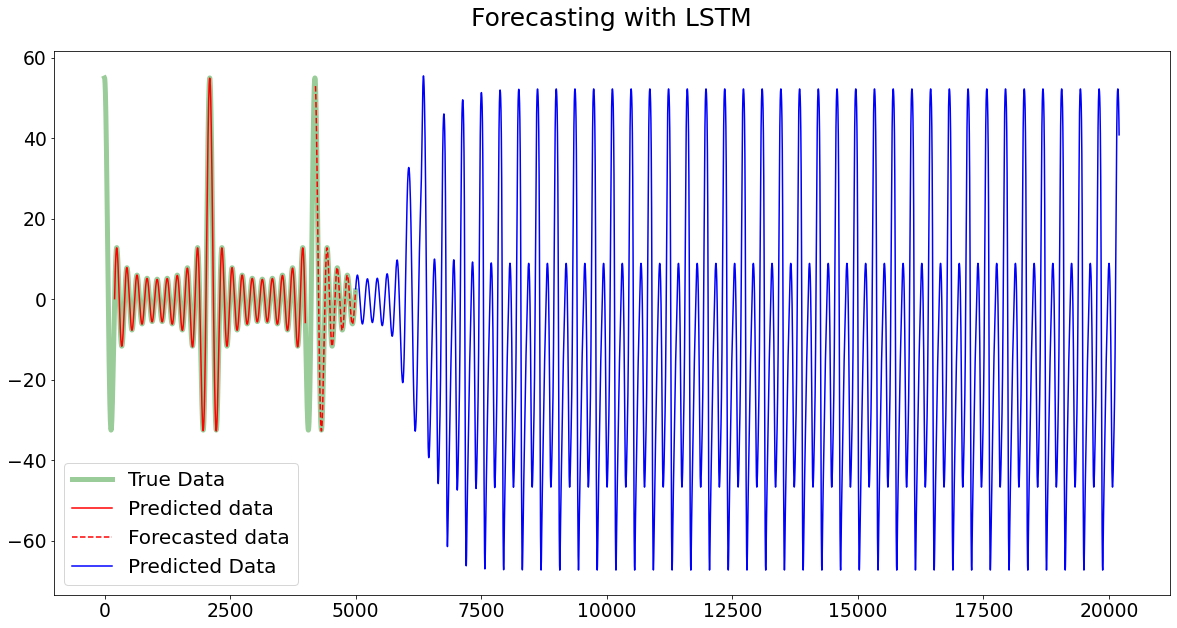

In [23]:
N = 5000
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# load the dataset
X = np.linspace(0, 15, N)
difference = X[1]-X[0]
Y = 10*(np.cos(10*X)) + 9*(np.cos(9*X)) + 8*(np.cos(8*X)) + \
7*(np.cos(7*X)) + 6*(np.cos(6*X)) + 5*(np.cos(5*X)) + 4*(np.cos(4*X)) +\
3*(np.cos(3*X)) + 2*(np.cos(2*X)) + np.cos(X)


dataset = Y.reshape(Y.size, 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * (0.8))
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


# reshape into X=t and Y=t+1
look_back = 200
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


# reshape input to be [samples, time steps, rows, columns, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, look_back, 1))
testX = np.reshape(testX, (testX.shape[0], 1, look_back, 1))


# create and fit the LSTM network
keras.backend.clear_session()
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, look_back, 1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
es = EarlyStopping(monitor='loss', mode = 'min', verbose=1, patience = 20, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False )
model.summary()
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=0, callbacks=[es,tqdm_callback])


# make predictions
trainPredict = model.predict(trainX)  
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)

trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset), 'g', linewidth=5, alpha=0.4, label='True Data')
plt.plot(trainPredictPlot, color = 'red', label = 'Predicted data')
plt.plot(testPredictPlot, '--' , color = 'red', label = 'Forecasted data')
plt.legend()
plt.title('Forecasting with LSTM')

##########################################################################################################

#Prediction
    
num_pred = 15000

#Create dataset for network
Input = []
for i in range(0,len(dataset),look_back):
  temp = np.array([])
  for j in range(look_back):
    temp = np.append(temp,float(dataset[i+j]))
  Input.append(temp)

# Network Prediction

x = list(Input[-1])

for i in range(int(num_pred)+1):
  data = np.array(x[i:i+look_back])
  data = data.reshape(1, 1, look_back, 1)
  result = model.predict(data)
  x.append(float(result))

x = np.array(x)


x = np.reshape(x,(x.shape[0],1))
PredictPlot = scaler.inverse_transform(x)
res = np.arange(N,N+len(Y[-look_back:])+num_pred+1)

plt.plot(res, PredictPlot, label = 'Predicted Data', c = 'b')

plt.legend()


plt.show()


In [ ]:
def create_dataset(dataset, look_back_in, look_back_out):
    dataX, dataY = [], []
    for i in range(len(dataset)):
        a = i + look_back_in
        b = a + look_back_out
        if b > len(dataset)-1:
          break
        data_x, data_y = dataset[i:a], dataset[a:b]
        dataX.append(data_x)
        dataY.append(data_y)
    return np.array(dataX), np.array(dataY)

# load the dataset
X = np.linspace(0, 15, N)
difference = X[1]-X[0]
Y = 10*(np.cos(10*X)) + 9*(np.cos(9*X)) + 8*(np.cos(8*X)) + \
7*(np.cos(7*X)) + 6*(np.cos(6*X)) + 5*(np.cos(5*X)) + 4*(np.cos(4*X)) +\
3*(np.cos(3*X)) + 2*(np.cos(2*X)) + np.cos(X)


dataset = Y.reshape(Y.size, 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * (0.8))
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]


# reshape into X=t and Y=t+1
look_back_in,look_back_out = 500, 200
trainX, trainY = create_dataset(train, look_back_in, look_back_out)
testX, testY = create_dataset(test, look_back_in, look_back_out)


# reshape input to be [samples, time steps, rows, columns, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


# create and fit the LSTM network
keras.backend.clear_session()
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1,look_back_in)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(look_back_out))
model.compile(loss='mean_squared_error', optimizer='adam')
es = EarlyStopping(monitor='loss', mode = 'min', verbose=1, patience = 20, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False, )
model.summary()
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=0, callbacks=[es,tqdm_callback])


# make predictions
trainPredict = model.predict(trainX)  
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)

trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset), 'g', linewidth=5, alpha=0.4, label='True Data')
plt.plot(trainPredictPlot, color = 'red', label = 'Predicted data')
plt.plot(testPredictPlot, '--' , color = 'red', label = 'Forecasted data')
plt.legend()
plt.title('Forecasting with LSTM')

##########################################################################################################

#Prediction
    
num_pred = 15000

#Create dataset for network
Input = []
for i in range(0,len(dataset),look_back_in):
  temp = np.array([])
  for j in range(look_back):
    temp = np.append(temp,float(dataset[i+j]))
  Input.append(temp)

# Network Prediction

x = list(Input[-1])

for i in range(int(num_pred)+1):
  data = np.array(x[i:i+look_back_in])
  data = data.reshape(1, look_back_in)
  result = model.predict(data)
  x.append(float(result))

x = np.array(x)
x = np.reshape(x,(x.shape[0],1))
PredictPlot = scaler.inverse_transform(x)
res = np.arange(N,N+len(Y[-look_back:])+num_pred+1)

plt.plot(res, PredictPlot, label = 'Predicted Data', c = 'b')

plt.legend()


plt.show() 


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            240400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
Total params: 341,000
Trainable params: 341,000
Non-trainable params: 0
_________________________________________________________________


ValueError: ignored

In [ ]:
size = 8
def network(L, sequence_size, N):
  input_data = L
  Data = []
  for i in range(len(L)-sequence_size):
    q = 0
    w = []
    while q<sequence_size:
      w.append(L[i+q])
      q += 1
    Data.append(w)
    
  Target = []
  for i in range(sequence_size,len(L)):
    Target.append(L[i])

  data = np.array(Data, dtype=float)
  target = np.array(Target, dtype=float)
  data = data.reshape(data.shape[0], data.shape[1], 1)

  x_train = data
  y_train = target

  keras.backend.clear_session()
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(sequence_size, 1), return_sequences=True))
  model.add(LSTM(100, activation='relu', input_shape=(sequence_size, 1), return_sequences=True))
  model.add(LSTM(100, activation='relu', input_shape=(sequence_size, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  es = EarlyStopping(monitor='loss', mode = 'min', verbose=1, patience = 20, restore_best_weights=True  )

  history = model.fit(x_train, y_train, epochs=6000, verbose=0, callbacks=[es], batch_size = 5)
  
  results = model.predict(x_train)
  w = 0
  while w < N:
    X = [[]]
    q = sequence_size
    while q > 0:
      X[0].append([L[-q]])
      q -= 1
    X = np.array(X)
    results = model.predict(X)
    L.append(float(results))
    w += 1
  print(L)
  plt.scatter(range(len(L)),L, label = "Sequencing of %d elements"%(sequence_size))
  plt.scatter(range(9),L[:9], color = 'black')
  plt.xticks([])
  plt.title("Sequence Prediction using LSTM")
  
  plt.legend()

Restoring model weights from the end of the best epoch
Epoch 00392: early stopping
[10, 20, 30, 40, 50, 60, 70, 80, 90, 99.71495819091797, 109.1924057006836, 118.38611602783203, 127.26567077636719, 135.8130645751953, 144.01959228515625, 151.88369750976562, 159.408935546875, 166.60256958007812, 173.47433471679688, 180.03567504882812, 186.29896545410156]
Restoring model weights from the end of the best epoch
Epoch 00448: early stopping
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100.38699340820312, 110.8946762084961, 121.95108032226562, 133.32098388671875, 145.3709716796875, 157.8984832763672, 171.20733642578125, 185.13453674316406, 199.91685485839844, 215.43275451660156, 231.872314453125, 249.1470184326172]
Restoring model weights from the end of the best epoch
Epoch 00160: early stopping
[10, 20, 30, 40, 50, 60, 70, 80, 90, 102.56102752685547, 115.53223419189453, 129.59991455078125, 146.3571319580078, 164.10646057128906, 183.78091430664062, 206.2692413330078, 230.43646240234375, 257.248077392

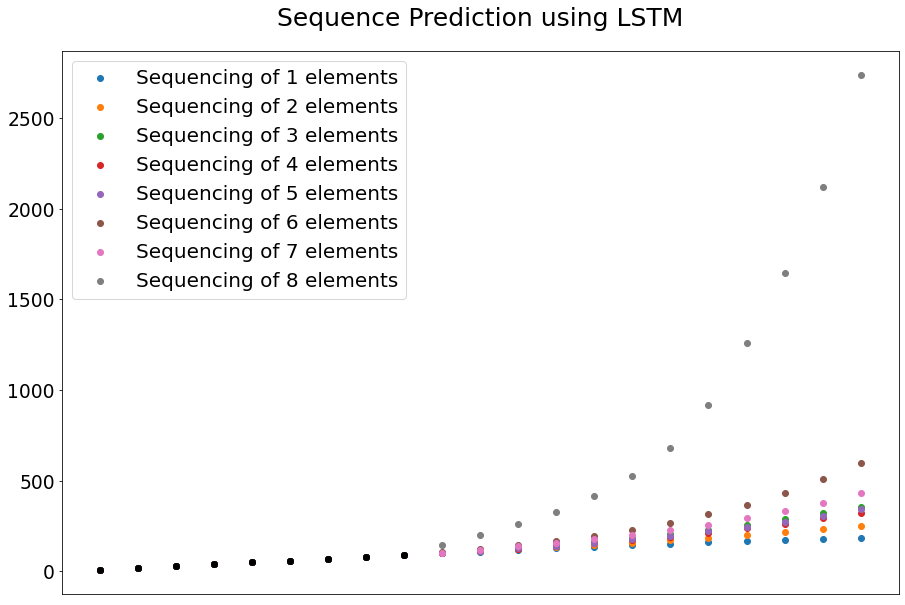

<Figure size 1440x720 with 0 Axes>

In [ ]:
for i in range(1,size+1):
  network([10, 20, 30, 40, 50, 60, 70, 80, 90], i, 12)

plt.figure(figsize=(20,10))
plt.show()